In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/child-mindset-institution/sample_submission.csv
/kaggle/input/child-mindset-institution/data_dictionary.csv
/kaggle/input/child-mindset-institution/train.csv
/kaggle/input/child-mindset-institution/test.csv
/kaggle/input/child-mindset-institution/series_test.parquet/id=00115b9f/part-0.parquet
/kaggle/input/child-mindset-institution/series_test.parquet/id=001f3379/part-0.parquet
/kaggle/input/child-mindset-institution/series_train.parquet/id=0745c390/part-0.parquet
/kaggle/input/child-mindset-institution/series_train.parquet/id=eaab7a96/part-0.parquet
/kaggle/input/child-mindset-institution/series_train.parquet/id=8ec2cc63/part-0.parquet
/kaggle/input/child-mindset-institution/series_train.parquet/id=b2987a65/part-0.parquet
/kaggle/input/child-mindset-institution/series_train.parquet/id=7b8842c3/part-0.parquet
/kaggle/input/child-mindset-institution/series_train.parquet/id=b120a337/part-0.parquet
/kaggle/input/child-mindset-institution/series_train.parquet/id=5f9dddb4/part

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from colorama import Fore, Style
from IPython.display import clear_output
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

In [3]:
train=pd.read_csv('/kaggle/input/child-mindset-institution/train.csv')
test=pd.read_csv('/kaggle/input/child-mindset-institution/test.csv')
sample=pd.read_csv('/kaggle/input/child-mindset-institution/sample_submission.csv')
sii_labels =['None','Mild','Moderate','Severe']

In [4]:
train.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
count,3960.000000,3960.000000,2421.000000,3022.000000,3027.000000,3076.000000,898.000000,2954.000000,2967.000000,2954.000000,...,2728.000000,2725.000000,2728.000000,2730.000000,2733.000000,2736.000000,2609.000000,2606.000000,3301.000000,2736.000000
mean,10.433586,0.372727,65.454771,19.331929,55.946713,89.038615,27.278508,69.648951,81.597236,116.983074,...,1.452346,1.627890,1.613636,1.158974,0.943652,27.896199,41.088923,57.763622,1.060588,0.580409
std,3.574648,0.483591,22.341862,5.113934,7.473764,44.569040,5.567287,13.611226,13.665196,17.061225,...,1.495600,1.445622,1.529178,1.343661,1.185460,20.338853,10.427433,13.196091,1.094875,0.771122
min,5.000000,0.000000,25.000000,0.000000,33.000000,0.000000,18.000000,0.000000,27.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,38.000000,0.000000,0.000000
25%,8.000000,0.000000,59.000000,15.869350,50.000000,57.200000,23.000000,61.000000,72.000000,107.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,33.000000,47.000000,0.000000,0.000000
50%,10.000000,0.000000,65.000000,17.937682,55.000000,77.000000,26.000000,68.000000,81.000000,114.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,26.000000,39.000000,55.000000,1.000000,0.000000
75%,13.000000,1.000000,75.000000,21.571244,62.000000,113.800000,30.000000,76.000000,90.500000,125.000000,...,2.000000,3.000000,2.000000,2.000000,1.000000,41.000000,46.000000,64.000000,2.000000,1.000000
max,22.000000,1.000000,999.000000,59.132048,78.500000,315.000000,50.000000,179.000000,138.000000,203.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,93.000000,96.000000,100.000000,3.000000,3.000000


In [5]:
train_missing=train.isnull().sum()
train_not_missing=train.count(numeric_only=False)
train_missing=train_missing/(train_missing+train_not_missing)
train_missing=train_missing[train_missing>0.2]
train_missing=train_missing.to_frame()
train_missing.describe()
#74 features have more than 20% of missing values in the training data. The max % of missing value is 88%.
#Therefore, the train data is needed to fill missing value before processing.

,0
count,74.000000
mean,0.441489
std,0.167773
min,0.223232
25%,0.310417
50%,0.417045
75%,0.497222
max,0.880051


In [6]:
 train.groupby('sii').size()
#sii,the targeted value, is not evenly distributed in the train data. 

sii
0.0    1594
1.0     730
2.0     378
3.0      34
dtype: int64

In [7]:
test.describe()
# there are some features in train data that are missing in test data. 

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday
count,20.000000,20.000000,8.000000,13.000000,13.000000,13.000000,5.000000,11.000000,12.000000,11.000000,...,8.000000,8.000000,8.000000,8.000000,8.000000,1.00,9.000000,10.000000,10.00000,16.000000
mean,10.750000,0.400000,62.500000,19.835939,52.961538,79.200000,25.400000,70.545455,81.666667,117.545455,...,28.486750,15.457795,56.989275,25.985962,45.167825,1.04,2.372333,36.800000,52.30000,1.437500
std,3.725799,0.502625,11.275764,4.927625,6.942357,23.632181,3.130495,18.806189,9.316001,21.262002,...,5.099449,4.021153,14.490362,7.479799,11.940000,NaN,1.080099,5.533735,7.02456,1.152895
min,5.000000,0.000000,50.000000,14.035590,37.500000,46.000000,22.000000,57.000000,70.000000,95.000000,...,21.035200,8.895360,38.917700,15.410700,27.055200,1.04,1.100000,27.000000,40.00000,0.000000
25%,9.000000,0.000000,51.000000,16.861286,48.000000,60.200000,24.000000,60.500000,74.500000,102.500000,...,24.230725,13.815400,44.627250,19.801775,37.245575,1.04,1.270000,33.500000,47.75000,0.000000
50%,10.000000,0.000000,63.000000,18.292347,55.000000,81.600000,24.000000,63.000000,80.000000,116.000000,...,29.470400,16.402450,59.199050,26.337750,46.608850,1.04,2.340000,37.500000,53.50000,2.000000
75%,12.250000,1.000000,71.000000,21.079065,57.750000,85.600000,27.000000,73.000000,90.250000,119.500000,...,31.398725,17.674625,65.222050,30.421100,51.860475,1.04,3.020000,39.750000,55.75000,2.000000
max,19.000000,1.000000,80.000000,30.094649,60.000000,121.600000,30.000000,123.000000,97.000000,163.000000,...,36.057200,20.902000,79.698200,36.223200,63.126500,1.04,4.110000,46.000000,64.00000,3.000000


In [8]:
features_not_in_test=[f for f in train.columns if f not in test.columns]
features_not_in_test.remove('sii')
train=train.drop(features_not_in_test,axis=1)
train.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
count,3960.000000,3960.000000,2421.000000,3022.000000,3027.000000,3076.000000,898.000000,2954.000000,2967.000000,2954.000000,...,1991.00000,1991.000000,1991.000000,1991.000000,475.000000,1721.000000,2609.000000,2606.000000,3301.000000,2736.000000
mean,10.433586,0.372727,65.454771,19.331929,55.946713,89.038615,27.278508,69.648951,81.597236,116.983074,...,20.02299,67.301883,34.389466,53.998726,2.178853,2.589550,41.088923,57.763622,1.060588,0.580409
std,3.574648,0.483591,22.341862,5.113934,7.473764,44.569040,5.567287,13.611226,13.665196,17.061225,...,70.21561,108.705918,84.050607,129.362539,0.849476,0.783937,10.427433,13.196091,1.094875,0.771122
min,5.000000,0.000000,25.000000,0.000000,33.000000,0.000000,18.000000,0.000000,27.000000,0.000000,...,4.63581,23.620100,4.655730,20.589200,0.660000,0.580000,17.000000,38.000000,0.000000,0.000000
25%,8.000000,0.000000,59.000000,15.869350,50.000000,57.200000,23.000000,61.000000,72.000000,107.000000,...,12.98315,45.204100,21.141550,35.887000,1.490000,2.020000,33.000000,47.000000,0.000000,0.000000
50%,10.000000,0.000000,65.000000,17.937682,55.000000,77.000000,26.000000,68.000000,81.000000,114.000000,...,16.43880,56.996400,27.415100,44.987000,2.010000,2.540000,39.000000,55.000000,1.000000,0.000000
75%,13.000000,1.000000,75.000000,21.571244,62.000000,113.800000,30.000000,76.000000,90.500000,125.000000,...,22.16760,77.105650,38.179400,60.271050,2.780000,3.160000,46.000000,64.000000,2.000000,1.000000
max,22.000000,1.000000,999.000000,59.132048,78.500000,315.000000,50.000000,179.000000,138.000000,203.000000,...,3108.17000,4683.710000,3607.690000,5690.910000,4.710000,4.790000,96.000000,100.000000,3.000000,3.000000


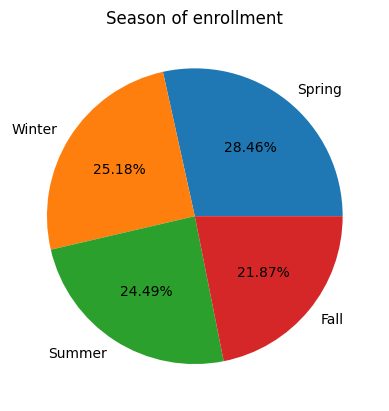

In [9]:
#Demographic info about the train data 
#Enrollment by seasons is evently  
vc=train['Basic_Demos-Enroll_Season'].value_counts()
vc=vc.to_frame(name="Count")
vc['index']=vc.index
plt.pie(vc['Count'],labels=vc['index'],autopct = "%.2f%%")
plt.title('Season of enrollment')
plt.show()


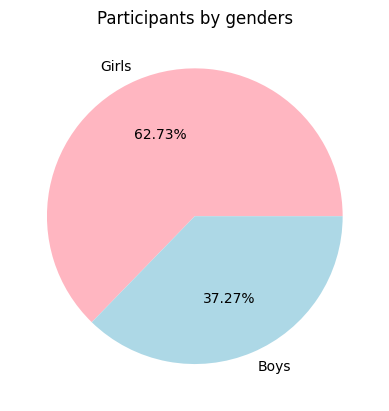

In [10]:
# Participants are more girls than boys
vc=train['Basic_Demos-Sex'].value_counts()
vc=vc.to_frame(name="Count")
plt.pie(vc['Count'],labels=['Girls','Boys'],autopct = "%.2f%%",colors=["lightpink", "lightblue"])
plt.title('Participants by genders')
plt.show()

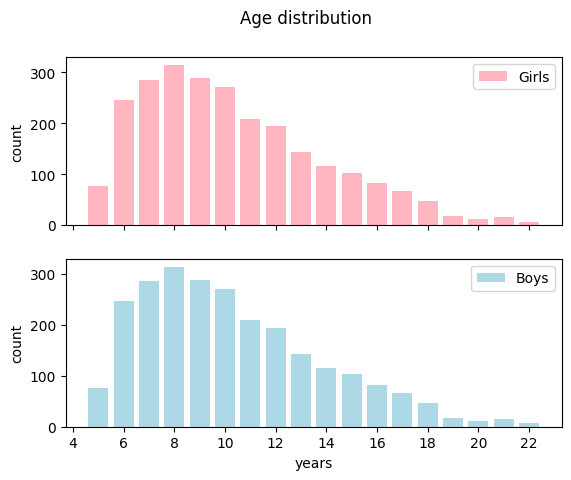

In [11]:
# Age distribution by genders is quite similar with a right skew shape. In both genders, mode of age is 8. 
vc = train.get(['Basic_Demos-Sex','Basic_Demos-Age'])
vc = vc.groupby(['Basic_Demos-Sex']).value_counts()
vc = vc.to_frame(name='counts')
for i in vc.index.names:
    vc[i] = vc.index.get_level_values(i)
_, axs = plt.subplots(2, 1, sharex=True)
for sex in range(2):
    ax = axs.ravel()[sex]
    ax.bar(vc['Basic_Demos-Age'],
           vc['counts'],
           color=['lightpink', 'lightblue'][sex],
           label=['Girls', 'Boys'][sex])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('count')
    ax.legend()
plt.suptitle('Age distribution')
axs.ravel()[1].set_xlabel('years')
plt.show()

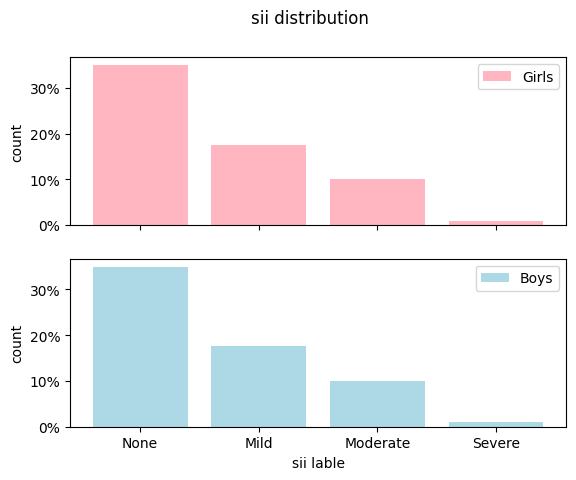

In [12]:
#sii distribution by genders is quite similar with a right skew shape. In both genders, mode of sii label is none.
vc = train.get(['Basic_Demos-Sex','sii'])
vc = vc.groupby(['Basic_Demos-Sex']).value_counts()
vc = vc.to_frame(name='counts')
for i in vc.index.names:
    vc[i] = vc.index.get_level_values(i)
_, axs = plt.subplots(2, 1, sharex=True)
for sex in range(2):
    ax = axs.ravel()[sex]
    ax.bar(vc['sii'],
           vc['counts']/vc['counts'].sum(),
           color=['lightpink', 'lightblue'][sex],
           label=['Girls', 'Boys'][sex])
    ax.set_xticks(np.arange(4),sii_labels)
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1,decimals=0))
    ax.set_ylabel('count')
    ax.legend()
plt.suptitle('sii distribution')
axs.ravel()[1].set_xlabel('sii lable')
plt.show()

KNN

In [13]:
imputer=KNNImputer(n_neighbors=5)
numeric_cols = train.select_dtypes(include=['float64','int64']).columns
imputed_data=imputer.fit_transform(train[numeric_cols])
train_imputed=pd.DataFrame(imputed_data,columns=numeric_cols)

train_imputed['sii']=train_imputed['sii'].round().astype(int)
for col in train.columns:
    if col not in numeric_cols:
        train_imputed[col]=train[col]
        
train=train_imputed

Feature engineering 

In [14]:
def feature_engineering(df):
    numerics=['int16','int32','int64','float16','float32','float64']
    numeric_df=df.select_dtypes(include=numerics).copy()
    Physical_Season=df['Physical-Season']
    Physical_Season = pd.get_dummies(Physical_Season).astype(int)
    SDS_Season=df['SDS-Season']
    SDS_Season = pd.get_dummies(SDS_Season).astype(int).rename(columns=lambda x:'SDS_' +str(x))
    df=pd.concat([numeric_df,Physical_Season,SDS_Season],axis=1)
    df['BMI_Age']=df['Physical-BMI']/df['Basic_Demos-Age']
    df['Internet_Hours_Age']=df['PreInt_EduHx-computerinternet_hoursday']*df['Basic_Demos-Age']
    df['PAQ_A_BMI']=df['PAQ_A-PAQ_A_Total']/df['BIA-BIA_BMI']
    df['PAQ_C_BMI']=df['PAQ_C-PAQ_C_Total']/df['BIA-BIA_BMI']
    df['SDS_Age']=df['SDS-SDS_Total_T']*df['Basic_Demos-Age']
    return df
    

In [15]:
train=feature_engineering(train)
test=feature_engineering(test)

In [16]:
def quadratic_weight_kappa(y_true,y_pred):
    return cohen_kappa_score(y_true,y_pred,weights='quadratic')
def threshold_Rounder(oof_non_rounded,thresholds):
    return np.where(oof_non_rounded<thresholds[0],0,
                   np.where(oof_non_rounded<thresholds[1],1,
                           np.where(oof_non_rounded<thresholds[2],2,3)))
def evaluate_prediction(thresholds, y_true,oof_non_rounded):
    rounded_p=threshold_Rounder(oof_non_rounded,thresholds)
    return -quadratic_weight_kappa(y_true,rounded_p)

Model

In [17]:
SEED=42
n_splits=5

In [18]:
def TrainML(model_class,test_data):
    X=train.drop(['sii'],axis=1)
    y=train['sii']
    
    SKF=StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=SEED)
    
    train_S=[]
    test_S=[]

    oof_non_rounded=np.zeros(len(y),dtype=float)
    oof_rounded=np.zeros(len(y),dtype=int)
    test_preds = np.zeros((len(test_data),n_splits))

    for fold, (train_idx,test_idx)in enumerate(tqdm(SKF.split(X,y),desc = "Training Folds",total=n_splits)):
       X_train, X_test=X.iloc[train_idx],X.iloc[test_idx]
       y_train, y_test=y.iloc[train_idx],y.iloc[test_idx]

       model=clone(model_class)
       model.fit(X_train,y_train)

       y_train_pred=model.predict(X_train)
       y_test_pred=model.predict(X_test)

       oof_non_rounded[test_idx]=y_test_pred
       y_test_pred_rounded = y_test_pred.round(0).astype(int)
       oof_rounded[test_idx]=y_test_pred_rounded

       train_kappa=quadratic_weight_kappa(y_train,y_train_pred.round(0).astype(int))
       test_kappa=quadratic_weight_kappa(y_test,y_test_pred_rounded)

       train_S.append(train_kappa)
       test_S.append(test_kappa)

       test_preds[:,fold]=model.predict(test_data)
       
       print(f"Fold{fold+1}-TrainQWK:{train_kappa:.4f},Validation QWK:{test_kappa:.4f}")
       clear_output(wait=True)
   
    print(f"Mean Train QWK -->{np.mean(train_S):.4f}")  
    print(f"Mean Validation QWK -->{np.mean(test_S):.4f}") 

    KappaOPtimizer=minimize(evaluate_prediction,x0=[0.5,1.5,2.5],args=(y,oof_non_rounded),method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."

    oof_tuned=threshold_Rounder(oof_non_rounded,KappaOPtimizer.x)
    tKappa=quadratic_weight_kappa(y,oof_tuned)

    print(f"---->||Optimized QMK SCORE::{tKappa:.3f}")
    
    tpm=test_preds.mean(axis=1)
    tpTuned=threshold_Rounder(tpm,KappaOPtimizer.x)

    submission=pd.DataFrame({'id':sample['id'],'sii':tpTuned})
    return submission

In [19]:
#Model parameter:
#Light Gradient Boosting Regressor
LGBM_params={
    'n_estimators': 200,
    'learning_rate': 0.05,
    'max_depth': 12,
    'feature_fraction':0.8,
    'bagging_fraction':0.8,
    'bagging_freq':4,
    'lamda_l1':8,
    'lamda_l2':0.05,
   }
#XGBoost:
XGB_params={
    'n_estimators': 200,
    'learning_rate': 0.05,
    'max_depth': 12,
    'subsample':0.5,
    'colsample_bytree': 0.5,
    'reg_alpha': 0.5,
    'reg_lambda': 1,
    'random_state':SEED
}

In [20]:
Light=LGBMRegressor(**LGBM_params,random_state=SEED,verbose=-1)
XGB_model=XGBRegressor(**XGB_params)

In [21]:
voting_model=VotingRegressor(estimators=[('lightgbm',Light),('xgboost',XGB_model)])
submission = TrainML(voting_model,test)

Training Folds: 100%|██████████| 5/5 [00:23<00:00,  4.61s/it]

Mean Train QWK -->0.9802
Mean Validation QWK -->0.4766
---->||Optimized QMK SCORE::0.499


Hyperparameter Tuning - Randomized Search CV

In [22]:
# Light Gradient Boosting Regressor
LGBM_param_dist = {
    'n_estimators': np.arange(200,500,50),
    'learning_rate': np.linspace(0.01,0.1,10),
    'max_depth': np.arange(4,14,2),
    'feature_fraction':np.linspace(0.5,1.0,10),
    'bagging_fraction':np.linspace(0.5,1.0,10),
    'bagging_freq':np.arange(2,10,2),
    'lamda_l1':np.arange(5,15,2),
    'lamda_l2':np.linspace(0.01,1.0,10),
   }
#XGBoost:
XGB_param_dist={
    'n_estimators': np.arange(200,500,50),
    'learning_rate': np.linspace(0.01,0.1,10),
    'max_depth': np.arange(4,10,2),
    'subsample':np.linspace(0.5,1.0,10),
    'colsample_bytree':np.linspace(0.5,1.0,10),
    'reg_alpha':np.linspace(0.5,1.5,10),
    'reg_lambda':np.linspace(1,10,10),
    }


In [23]:
#X_train, y_train
X_train=train.drop(['sii'],axis=1)
y_train=train['sii']

In [24]:
#LBGM
LBGM_search=RandomizedSearchCV(Light,LGBM_param_dist,n_iter=20,scoring='neg_mean_squared_error',cv=3,random_state=SEED)
LBGM_search.fit(X_train,y_train)
best_LGBM=LBGM_search.best_estimator_
#XGB
XGB_search=RandomizedSearchCV(XGB_model,XGB_param_dist,n_iter=20,scoring='neg_mean_squared_error',cv=3,random_state=SEED)
XGB_search.fit(X_train,y_train)
best_XGB=XGB_search.best_estimator_


In [25]:
best_LGBM

LGBMRegressor(bagging_fraction=0.5555555555555556, bagging_freq=4,
              feature_fraction=0.6111111111111112, lamda_l1=11, lamda_l2=1.0,
              learning_rate=0.020000000000000004, max_depth=8, n_estimators=250,
              random_state=42, verbose=-1)

In [26]:
best_XGB

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8333333333333333, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.020000000000000004, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=350, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [27]:
#Update hyperparameters
LGBM_params={
    'n_estimators': 250,
    'learning_rate': 0.02,
    'max_depth': 8,
    'feature_fraction':0.611,
    'bagging_fraction':0.556,
    'bagging_freq':4,
    'lamda_l1':11,
    'lamda_l2':1.0,
   }
#XGBoost:
XGB_params={
    'n_estimators': 350,
    'learning_rate': 0.02,
    'max_depth': 8,
    'subsample':0.5,
    'colsample_bytree': 0.5,
    'reg_alpha': 0.5,
    'reg_lambda': 1,
    'random_state':SEED
}

Light=LGBMRegressor(**LGBM_params,random_state=SEED,verbose=-1)
XGB_model=XGBRegressor(**XGB_params)
voting_model=VotingRegressor(estimators=[('lightgbm',Light),('xgboost',XGB_model)])
submission1 = TrainML(voting_model,test)

Training Folds: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]

Mean Train QWK -->0.8562
Mean Validation QWK -->0.4835
---->||Optimized QMK SCORE::0.514
